# 1. INTRODUCTION

# 2. DATA WRANGLING

## 2.1 Import Libraries

In [117]:
import numpy as np
import pandas as pd
import os
import re

#Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [118]:
#%conda install openpyxl

## 2.2 Import Data

In [119]:
df = pd.read_excel('../data/raw/online_retail_II.xlsx', sheet_name = 'Year 2010-2011')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [120]:
df.shape

(541910, 8)

## 2.3 Define Functions

Define a custom logging function to track changes to the dataset.

In [121]:
ChangeLogs = {}
def log_changes(num, desc):
    '''Custom function to update ChangeLogs{} dictionary with the number of changed records and the description of the changes.
    Input:
        num - number of changed records to track
        desc - free text description of the changes
    Return: None
    '''
    idx = len(ChangeLogs)
    ChangeLogs[idx] = {'Number': num, 'Description': desc}

## 2.4 Data Wrangling

### 2.4.1 Inspect columns

In [122]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [123]:
df.rename(columns = {'Customer ID':'CustomerID'}, inplace=True)
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'CustomerID', 'Country'],
      dtype='object')

### 2.4.2 Inspect/Resolve inconsistencies in values

In [124]:
df.describe()

,Quantity,InvoiceDate,Price,CustomerID
count,541910.000000,541910,541910.000000,406830.000000
mean,9.552234,2011-07-04 13:35:22.342307584,4.611138,15287.684160
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.080957,NaN,96.759765,1713.603074


#### 2.4.2.a Resolve CustomerID count

<font color='red'>Inconsistency Found:</font> CustomerID count is not the same as that of the Quantity

Find ratio of null CustomerIDs

In [125]:
rec_init = df.shape[0]
rec_init

541910

In [126]:
#Find ratio of Null Customer ID
rec_init = df.shape[0]
ratio_null_cust_id = round(len(df.loc[df['CustomerID'].isna()]) / len(df) * 100, 2)
print(f'Ratio of null customer IDs in the dataset: {ratio_null_cust_id}')

Ratio of null customer IDs in the dataset: 24.93


- Approximately 25% of Customer ID is (null). 
- As the focus of our model is on Customer Segmentation, (null) Customer ID is of no value to the analysis; therefore, it is imperative to drop the (null) values.

In [127]:
# Drop null rows in Customer id
df = df.dropna(subset = ['CustomerID'])

# Update Changes logs
log_changes(rec_init - len(df), 'Number of null Customer IDs dropped')

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406830 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406830 non-null  object        
 1   StockCode    406830 non-null  object        
 2   Description  406830 non-null  object        
 3   Quantity     406830 non-null  int64         
 4   InvoiceDate  406830 non-null  datetime64[ns]
 5   Price        406830 non-null  float64       
 6   CustomerID   406830 non-null  float64       
 7   Country      406830 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


#### 2.4.2.b Resolve CustomerID data type

<font color='red'>Inconsitency Found:</font> Customer ID is of type float, and the decimals removed because according to the documentation: 

- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
The decimals in this column should be removed.

In [129]:
#Convert Customer ID from Float to int
df['CustomerID'] = df['CustomerID'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406830 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406830 non-null  object        
 1   StockCode    406830 non-null  object        
 2   Description  406830 non-null  object        
 3   Quantity     406830 non-null  int64         
 4   InvoiceDate  406830 non-null  datetime64[ns]
 5   Price        406830 non-null  float64       
 6   CustomerID   406830 non-null  int64         
 7   Country      406830 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.9+ MB


In [130]:
df.describe()

,Quantity,InvoiceDate,Price,CustomerID
count,406830.000000,406830,406830.000000,406830.000000
mean,12.061276,2011-07-10 16:31:30.127424512,3.460507,15287.684160
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693065,NaN,69.315080,1713.603074


<font color='orange'>Inconsistencies Found: </font> Minimum Value for Quantity and Price is negative

#### 2.4.2.c Resolve negative quantities and price

In [131]:
#Inspect the negative quantities
df.loc[df['Quantity'] < 0].head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Compare negative values. Check if all these negative quantities are from Cancelled Invoices ( Invoices with "C" as a prefix )

In [132]:
#Compare negative values
df['Invoice'] = df['Invoice'].astype(str)
cancelled = df['Invoice'].str.contains(r'^[Cc]') 
negative = df['Quantity'] < 0
positive = df['Quantity'] >= 0

print(f'Negative quantities : {len(df.loc[df['Quantity'] < 0])}')
print(f'Cancelled Invoices: {len(df[cancelled])}')
print(f'Negative quantities with Cancelled invoices: {len(df[cancelled & ~positive])}' )
print(f'Positive quantities with Cancelled invoices: {len(df[cancelled & positive])}' )

Negative quantities : 8905
Cancelled Invoices: 8905
Negative quantities with Cancelled invoices: 8905
Positive quantities with Cancelled invoices: 0


Findings: All negative quantities are from Cancelled Invoices. 

Next Step: For this analysis, cancelled invoices will be dropped from the dataset

In [133]:
# Discard negative quantities ( this includes Cancelled invoices)
rec_init = len(df)
df = df[df['Quantity'] > 0]

log_changes(rec_init - len(df), 'Negative quantities or cancelled invoices excluded in the dataset')
print(f'Number of non-negative quantities: {len(df)}')

Number of non-negative quantities: 397925


In [134]:
df['Quantity'].describe()

count    397925.000000
mean         13.021793
std         180.419984
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [135]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
dtype: int64

#### 2.4.2.d Inspect/Resolve Invoices column

Check Invoices column. Per the description:

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 

In [136]:
#Check for incorrect invoices 
df['Invoice'] = df['Invoice'].astype(str)
df[df['Invoice'].str.match(r'^\d{5}$')].shape[0]

0

#### 2.4.2.e Inspect/Resolve Stock Codes column

Check Stock Codes. Per the description: 
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 

In [137]:
#Stock Codes with non-numeric codes
df['StockCode'] = df['StockCode'].astype(str)
notnum = df[df['StockCode'].str.match(r'^\D')]
notnum['StockCode'].value_counts()
notnum.groupby(['StockCode', 'Description']).agg({'StockCode': 'count'})

,,StockCode
StockCode,Description,
BANK CHARGES,Bank Charges,12
C2,CARRIAGE,133
DOT,DOTCOM POSTAGE,16
M,Manual,290
PADS,PADS TO MATCH ALL CUSHIONS,4
POST,POSTAGE,1100


Inspect the other values of the non-conforming stock codes for inconsitencies or irregularities

In [138]:
#Stock Codes with numeric codes followed by Characters
alphanum = df[df['StockCode'].str.match(r'\d{5}\D')]
alphanum.groupby(['StockCode', 'Description']).agg({'StockCode': 'count'})

,,StockCode
StockCode,Description,
10123C,HEARTS WRAPPING TAPE,3
10124A,SPOTS ON RED BOOKCOVER TAPE,5
10124G,ARMY CAMO BOOKCOVER TAPE,4
15044A,PINK PAPER PARASOL,79
15044B,BLUE PAPER PARASOL,48
...,...,...
90214U,"LETTER ""U"" BLING KEY RING",1
90214V,"LETTER ""V"" BLING KEY RING",3
90214W,"LETTER ""W"" BLING KEY RING",1


Analyze both non-numeric and alphanumeric tables of stock codes

In [139]:
print(f'Stock Codes with Letters only: {len(notnum)}')
print(f'Stock Codes with Alphanumeric characters: {len(alphanum)}')
nonconf = pd.concat([notnum, alphanum])
nonconf

Stock Codes with Letters only: 1555
Stock Codes with Alphanumeric characters: 33251


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583,France
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791,Netherlands
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662,Germany
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.00,14911,EIRE
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom
...,...,...,...,...,...,...,...,...
541778,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,2011-12-09 12:16:00,4.15,12713,Germany
541809,581579,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2011-12-09 12:19:00,1.79,17581,United Kingdom
541841,581580,84993A,75 GREEN PETIT FOUR CASES,2,2011-12-09 12:20:00,0.42,12748,United Kingdom
541847,581580,85049A,TRADITIONAL CHRISTMAS RIBBONS,1,2011-12-09 12:20:00,1.25,12748,United Kingdom


In [140]:
#Inspect the quantities with negative values
nonconf.loc[df['Quantity'] < 0].shape[0]

0

For this analysis, it is assumed that all the non-conforming stock codes are valid transactions done manually or automatically but outside the order placement process.\
This is because other columns for the non-conforming stock codes have no inconsistent values.

#### 2.4.2.f Inspect/Resolve Invoice Date column

Create a new month column (for later use)

In [141]:
df['Month'] = df['InvoiceDate'].dt.month
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12


Check month values

In [142]:
#Inspect no. of monthly transactions
df['Month'].value_counts().sort_index()

Month
1     21232
2     19928
3     27177
4     22644
5     28322
6     27185
7     26827
8     27013
9     40030
10    49557
11    64545
12    43465
Name: count, dtype: int64

### 2.4.3 Inspect/Resolve Duplicate records

In [143]:
print('Duplicates rows detected?:', df.duplicated().any())
print('No. of duplicates to be dropped ', len(df[df.duplicated()]))
rec_init = len(df)

df = df.drop_duplicates()
df

log_changes(rec_init-len(df), 'Dropped duplicates')

Duplicates rows detected?: True
No. of duplicates to be dropped  5192


### 2.4.5 Show changes logged

In [144]:
df_logs = pd.DataFrame(ChangeLogs).T
df_logs

,Number,Description
0,135080,Number of null Customer IDs dropped
1,8905,Negative quantities or cancelled invoices excl...
2,5192,Dropped duplicates


In [145]:
df.shape

(392733, 9)

# 3. EXPLORATORY DATA ANALYSIS

## 3.1 Import Additional libraries for EDA

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns 
import calendar as cal

## 3.2 Explore Data

In [147]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392733 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      392733 non-null  object        
 1   StockCode    392733 non-null  object        
 2   Description  392733 non-null  object        
 3   Quantity     392733 non-null  int64         
 4   InvoiceDate  392733 non-null  datetime64[ns]
 5   Price        392733 non-null  float64       
 6   CustomerID   392733 non-null  int64         
 7   Country      392733 non-null  object        
 8   Month        392733 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(4)
memory usage: 28.5+ MB


### 3.2.a Dealing with Price

In [149]:
df.describe()

,Quantity,InvoiceDate,Price,CustomerID,Month
count,392733.000000,392733,392733.000000,392733.000000,392733.000000
mean,13.153687,2011-07-10 19:15:57.956932608,3.125633,15287.728182,7.601946
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000,1.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13955.000000,5.000000
50%,6.000000,2011-07-31 12:02:00,1.950000,15150.000000,8.000000
75%,12.000000,2011-10-20 12:53:00,3.750000,16791.000000,11.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,12.000000
std,181.588189,NaN,22.240710,1713.570644,3.415026


Min in price is 0, and there's 40 records of it.\
Remove the rows from the dataset as it will impact the monetary component in the analysis.

In [150]:
df = df.query('Price > 0')

print('0 price in the dataset after changes: ',  np.sum(df.Price <= 0))
df['Price'].describe()

0 price in the dataset after changes:  0


count    392693.000000
mean          3.125952
std          22.241820
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: Price, dtype: float64

### 3.2.b Dealing with Invoice Date

Transform Date Column Type and check range.

In [151]:
#Transform Invoice Date column to DateTime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.normalize()

print(min(df['InvoiceDate']), max(df['InvoiceDate']))

2010-12-01 00:00:00 2011-12-09 00:00:00


Filter dataset to only include dates later than 2011-01-01

In [152]:
df  = df[df['InvoiceDate'] >= '2011-01-01']

### 3.2.c Creation of Sales Column

In [153]:
#Create Sales column (Useful for RFM Analysis later)
df['Sales'] = df.Quantity * df.Price
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month,Sales
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04,1.95,13313,United Kingdom,1,19.5
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04,0.42,13313,United Kingdom,1,10.5
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04,0.42,13313,United Kingdom,1,10.5
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04,2.10,13313,United Kingdom,1,10.5
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04,1.25,13313,United Kingdom,1,12.5


In [154]:
df.shape

(367023, 10)

## 3.3 Summary Statistics

In [155]:
df.describe( include='all')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month,Sales
count,367023,367023,367023,367023.000000,367023,367023.000000,367023.000000,367023,367023.000000,367023.000000
unique,17132,3596,3784,NaN,NaN,NaN,NaN,36,NaN,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom,NaN,NaN
freq,542,1816,1809,NaN,NaN,NaN,NaN,325745,NaN,NaN
mean,NaN,NaN,NaN,13.189786,2011-07-25 03:02:48.816668416,3.124763,15271.672315,NaN,7.294273,22.660172
min,NaN,NaN,NaN,1.000000,2011-01-04 00:00:00,0.001000,12346.000000,NaN,1.000000,0.001000
25%,NaN,NaN,NaN,2.000000,2011-05-04 00:00:00,1.250000,13924.000000,NaN,5.000000,4.950000
50%,NaN,NaN,NaN,6.000000,2011-08-15 00:00:00,1.850000,15116.000000,NaN,8.000000,12.480000
75%,NaN,NaN,NaN,12.000000,2011-10-25 00:00:00,3.750000,16771.000000,NaN,10.000000,19.800000
max,NaN,NaN,NaN,80995.000000,2011-12-09 00:00:00,8142.750000,18287.000000,NaN,12.000000,168469.600000


df.describe( include='all')

### 3.1 Evaluate Categorical Variables

In [156]:

print('Unique Invoices: ', df.Invoice.nunique())
print('Unique Countries: ', df.Country.nunique())
print('Unique StockCodes: ', df.StockCode.nunique())
print('Unique Customer IDs: ', df.CustomerID.nunique())

Unique Invoices:  17132
Unique Countries:  36
Unique StockCodes:  3596
Unique Customer IDs:  4219


### 3.2 Extract Monthly Data

#### 3.2.a Monthly Sales

In [157]:
ms = df.groupby('Month')['Sales'].agg(['mean', 'median', 'sum']).reset_index()
ms

,Month,mean,median,sum
0,1,27.067911,12.60,568101.310
1,2,22.637010,13.20,446084.920
2,3,22.109481,12.75,594081.760
3,4,20.878809,12.75,468374.331
4,5,24.128349,15.00,677355.150
5,6,24.513335,12.60,660046.050
6,7,22.534345,12.50,598962.901
7,8,24.040726,13.91,644051.040
8,9,23.965570,13.52,950690.202
9,10,21.225226,10.50,1035642.450


#### 3.2.b Montly Quantities

In [158]:
mq = df.groupby('Month')['Quantity'].agg('sum')
mq = mq.reset_index()
mq

,Month,Quantity
0,1,348473
1,2,265027
2,3,347582
3,4,291366
4,5,372864
5,6,363014
6,7,367360
7,8,397373
8,9,543652
9,10,591543


### 3.3 Visualize sales and purchases

#### 3.3.1 Monthly Invoices and Purchases

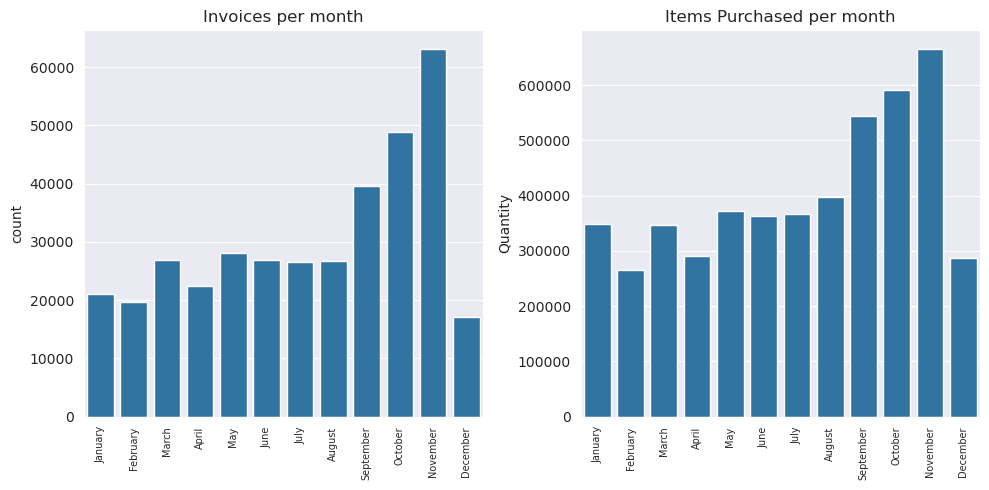

In [159]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.2, hspace=0.3)


sns.countplot(data=df, x=df.Month, ax=ax[0])
ax[0].set_title('Invoices per month')
ax[0].set_xticklabels([cal.month_name[i] for i in np.arange(1,13, 1)], rotation=90, size=7)
ax[0].set_xlabel('')

sns.barplot(data=mq, x=mq.Month, y=mq.Quantity, ax=ax[1])
ax[1].set_title('Items Purchased per month')
ax[1].set_xticklabels([cal.month_name[i] for i in np.arange(1,13, 1)], rotation=90, size=7)
ax[1].set_xlabel('')

plt.tight_layout()

#### 3.3.2 Montly Sales

Text(0.5, 1.0, 'Total Monthly Sales')

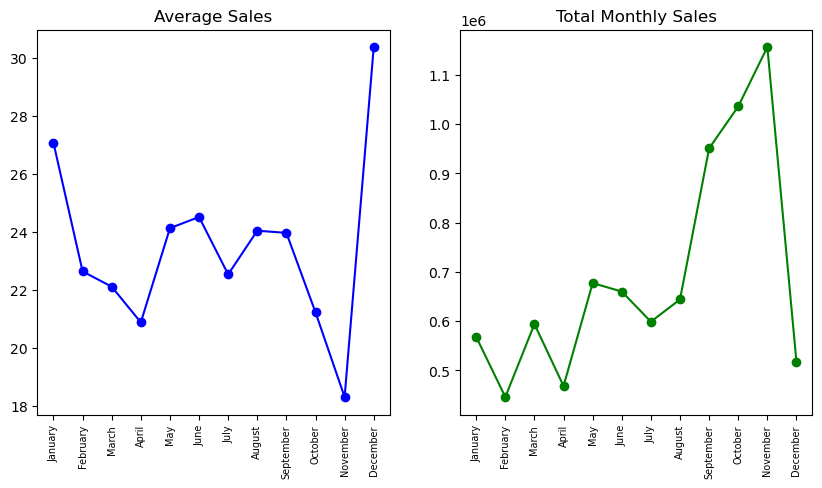

In [44]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.2, hspace=0.3)


ax[0].plot(ms['mean'], label='Average Sales', color='blue', marker='o')
ax[0].set_xticks(ms.Month.values - 1) 
ax[0].set_xticklabels([cal.month_name[i] for i in ms.Month.values], size=7) 
ax[0].tick_params('x', labelrotation=90)
ax[0].set_title('Average Sales')


ax[1].plot(ms['sum'], label='Total Sales', color='green', marker='o')
ax[1].set_xticks(ms.Month.values - 1) 
ax[1].set_xticklabels([cal.month_name[i] for i in ms.Month.values], size=7) 
ax[1].tick_params('x', labelrotation=90)
ax[1].set_title('Total Monthly Sales')

Investigate the steep decline in sales for the month of December (which is unusual for the amount of Sales during this time of the year)

In [45]:
print('% of December Transactions: ', round(len(df.query('Month == 12')) * 100 / len(df), 2), '%')
print('Latest December Transaction: ', df.query('Month == 12')['InvoiceDate'].max() )

% of December Transactions:  4.64 %
Latest December Transaction:  2011-12-09 00:00:00


Most recent invoice was recorded only until Dec 9. \
The transactions in the dataset appear incomplete as it did not capture the whole transactions for the month of December 2011.

### 3.4 Transform Data into Transactions per Customer

#### 3.4.a Determine Recency

Create a new Recency column and calculate the date difference.

In [46]:
recent_invdt = df['InvoiceDate'].max() #Ideally, should be the latest day of invoice (near today's date)

df_percust = df.groupby('CustomerID', as_index=False) \
    .agg( 
        LastPurchaseDate = ('InvoiceDate', 'max'),
        Frequency = ('Invoice', 'nunique'),
        Monetary = ('Sales', 'sum'))

df_percust['Recency'] = (recent_invdt - df_percust['LastPurchaseDate']).dt.days
df_percust.head()

,CustomerID,LastPurchaseDate,Frequency,Monetary,Recency
0,12346,2011-01-18,1,77183.60,325
1,12347,2011-12-07,6,3598.21,2
2,12348,2011-09-25,3,904.44,75
3,12349,2011-11-21,1,1757.55,18
4,12350,2011-02-02,1,334.40,310


### 3.5. Distribution of Recency, Frequency, and Monetary per Customer

Histogram

Text(0.5, 1.0, 'Monetary Distribution')

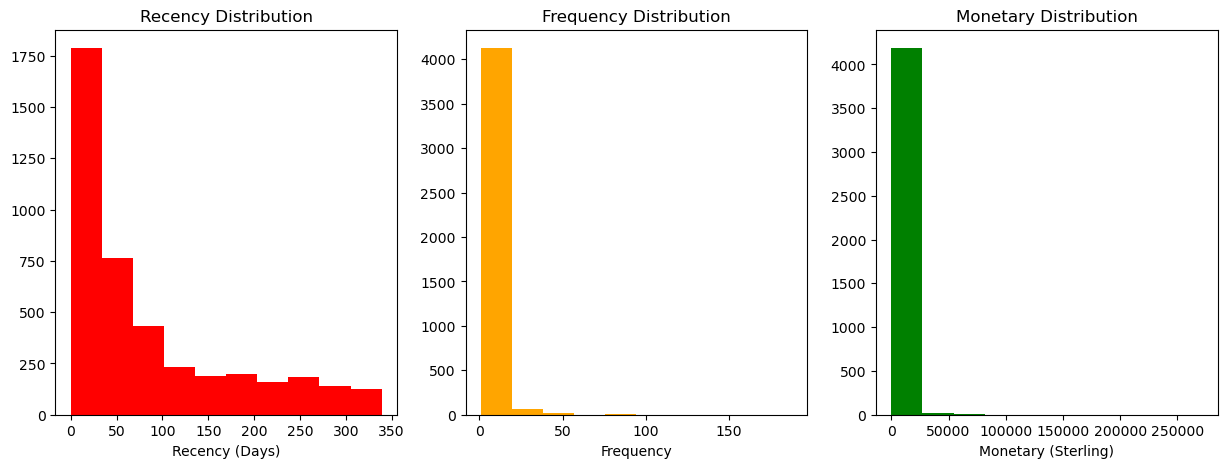

In [47]:
fig, ax= plt.subplots(1,3, figsize=(15,5))

#Recency
ax[0].hist(df_percust.Recency, bins=10, color='red')
ax[0].set_xlabel('Recency (Days)')
ax[0].set_title('Recency Distribution')

#Frequency
ax[1].hist(df_percust.Frequency, bins=10, color='orange')
ax[1].set_xlabel('Frequency')
ax[1].set_title('Frequency Distribution')

#Monetary
ax[2].hist(df_percust.Monetary, bins=10, color='green')
ax[2].set_xlabel('Monetary (Sterling)')
ax[2].set_title('Monetary Distribution')

Box plot

Text(0.5, 1.0, 'Monetary Boxplot')

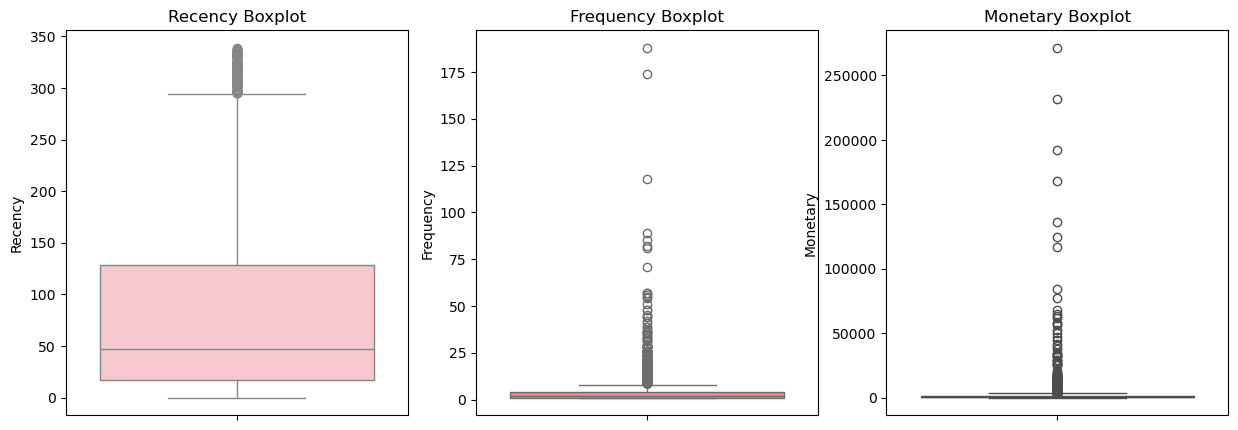

In [48]:
fig, ax= plt.subplots(1,3, figsize=(15,5))

#Recency
sns.boxplot(data=df_percust.Recency, color='pink', ax=ax[0])
ax[0].set_title('Recency Boxplot')

#Frequency
sns.boxplot(data=df_percust.Frequency, color='salmon', ax=ax[1])
ax[1].set_title('Frequency Boxplot')

#Monetary
sns.boxplot(data=df_percust.Monetary, color='lime', ax=ax[2])
ax[2].set_title('Monetary Boxplot')

There are many outliers as can be seen from the R/F/M boxplots. \
A separate analysis should be performed as they represent extreme behaviours by the customers, such as very big spending and very frequent purchases.

# 4. PRE-PROCESSING AND FEATURE ENGINEERING

The later part of EDA activities indicates the presence of outliers. \
Since the focus of this project is on clustering, only the non-outliers will be processed by the model. 

It is emparative to analyze the outliers as they represent extreme behaviours by the customers, such as high spending and very frequent purchases; therefore, that step will be performed after the modeling.


## 4.1 Outlier detection and handling 

### 4.1.1 Separate big spenders and frequent spenders from the rest of the data 

In [49]:
#Create a function for extracting outliers
def outliers(p_df, col):
    '''Function for computing outliers. 
    Input: (1)Dataframe, (2)column name.
    Return: rows of outliers in a dataframe'''

    q1 = p_df[col].quantile(0.25)
    q3 = p_df[col].quantile(0.75)
    iqr = q3 - q1
    outlier = p_df[( p_df[col] > (q3 + 1.5*iqr)) | (p_df[col] < (q1 - 1.5*iqr)) ]
    return outlier

In [50]:
#Big spenders: Monetaty outliers
m_outliers = outliers(df_percust, 'Monetary')

#Frequent buyers: Frequency outliers
f_outliers = outliers(df_percust, 'Frequency')

print('Monetary outliers: ', m_outliers.shape[0])
print('Frequency outliers: ', f_outliers.shape[0])

Monetary outliers:  402
Frequency outliers:  412


In [51]:
df_percust.shape

(4219, 5)

### 4.1.2 Separate and visualize non-outliers

First, back up df to df_eda

In [52]:
df_eda = df.copy(deep=True)
df_eda.shape

(367023, 10)

### 4.1.3 Subset the non-outliers to df

In [53]:
df = df_percust[ (~df_percust.index.isin(f_outliers.index)) &  (~df_percust.index.isin(m_outliers.index)) ]
print(f'No. of Non-outlier records:  {len(df)} from {len(df_percust)} or {round(len(df)*100/len(df_percust),2)} %' )

No. of Non-outlier records:  3674 from 4219 or 87.08 %


### 4.1.4 Visualize non-outliers based on Recency, Frequency, and Monetary

<Axes: ylabel='Monetary'>

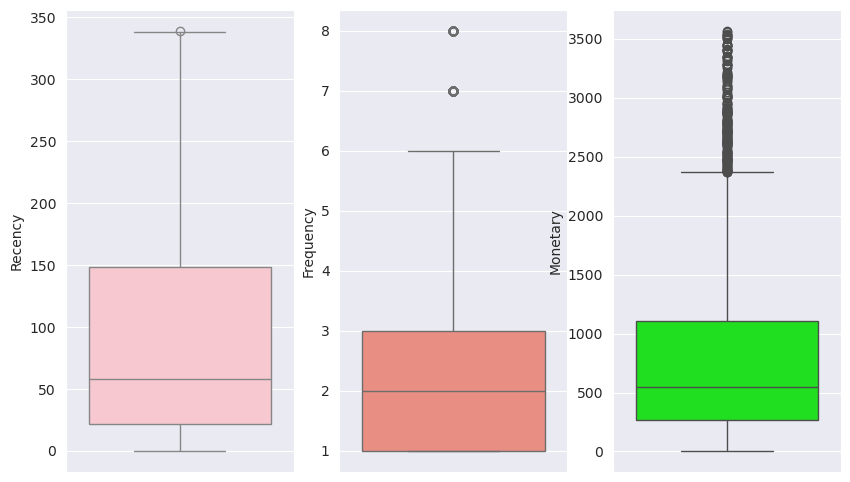

In [100]:
fig, ax = plt.subplots(1,3, figsize=(10,6))

sns.boxplot(data=df.Recency, color='pink', ax=ax[0])
sns.boxplot(data=df.Frequency, color='salmon', ax=ax[1])
sns.boxplot(data=df.Monetary, color='lime', ax=ax[2])

### 4.1.5 Plot a 3D scatterplot for Recency,Frequency, and Monetary.

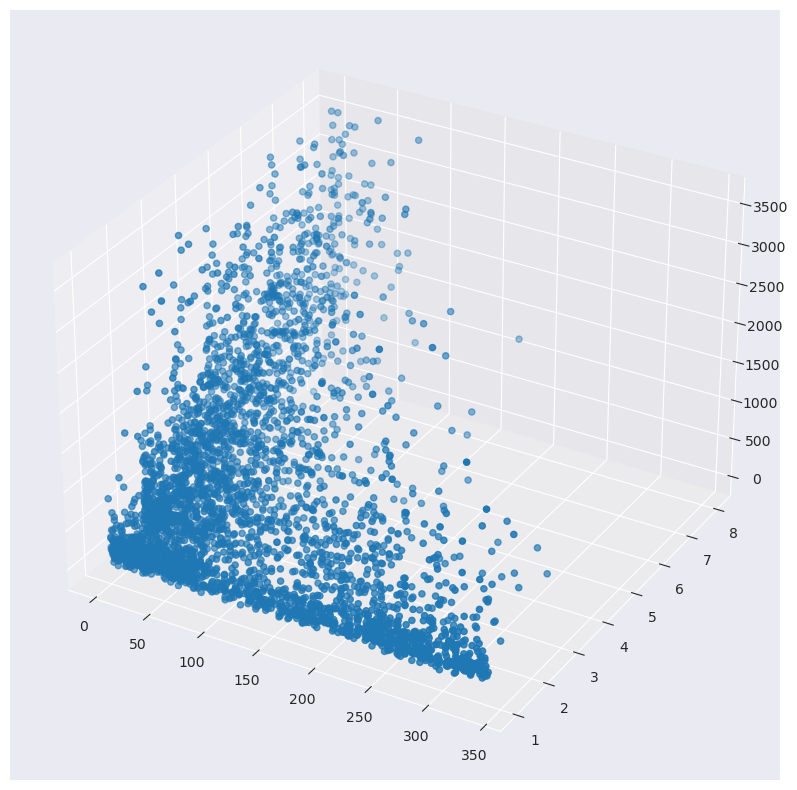

In [99]:
sns.set_style ("darkgrid")
plt.figure (figsize = (10,10))
seaborn_plt = plt.axes (projection='3d')
seaborn_plt.scatter3D(df.Recency, df.Frequency, df.Monetary)

## 4.2 Scaling

### 4.2.1 Prepare for scaling

The columns of interest are recency, frequency, and monetary, so all other columnns the dataset are be dropped.


In [56]:
df = df.drop('LastPurchaseDate', axis=1)
df = df.set_index('CustomerID')

#Back up the indices and columns
rfm_idx = df.index
rfm_cols = df.columns

df.head()

,Frequency,Monetary,Recency
CustomerID,,,
12348,3,904.44,75
12349,1,1757.55,18
12350,1,334.40,310
12352,8,2506.04,36
12353,1,89.00,204


### 4.2.2 Scale/Standarize the data

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(rfm_scaled, columns=rfm_cols, index=rfm_idx)
df_scaled


,Frequency,Monetary,Recency
CustomerID,,,
12348,0.276110,0.136242,-0.201490
12349,-0.843567,1.285555,-0.820832
12350,-0.843567,-0.631719,2.351934
12352,3.075301,2.293924,-0.625250
12353,-0.843567,-0.962323,1.200176
...,...,...,...
18278,-0.843567,-0.847945,-0.223222
18280,-0.843567,-0.838919,1.993368
18281,-0.843567,-0.973343,0.939401


Check if normalized. Mean ~ 0 and Standard Deviation ~ 1.

In [60]:
print(df_scaled.mean())
print('\n', df_scaled.std(ddof=0))

Frequency    4.254747e-17
Monetary    -7.735903e-17
Recency      2.514169e-17
dtype: float64

 Frequency    1.0
Monetary     1.0
Recency      1.0
dtype: float64


### 4.2.3 Visualize the distribution before and after standardization

Before standardization:

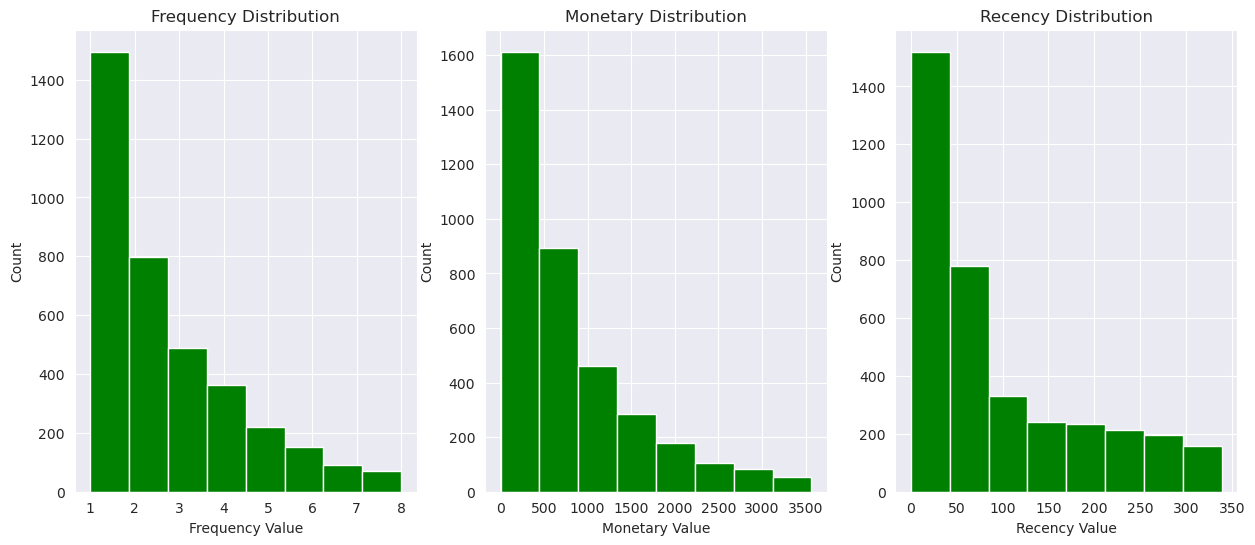

In [61]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15,6), squeeze=False)

for idx, col in enumerate(df.columns):

    axes[0][idx].hist(df[col], bins=8, color='green')
    axes[0][idx].set_xlabel(col + ' Value')
    axes[0][idx].set_ylabel('Count')
    # plt.axvline(df_rfm_col[col].mean(), size)
    axes[0][idx].set_title( col + ' Distribution')

plt.show()  

After standardization:

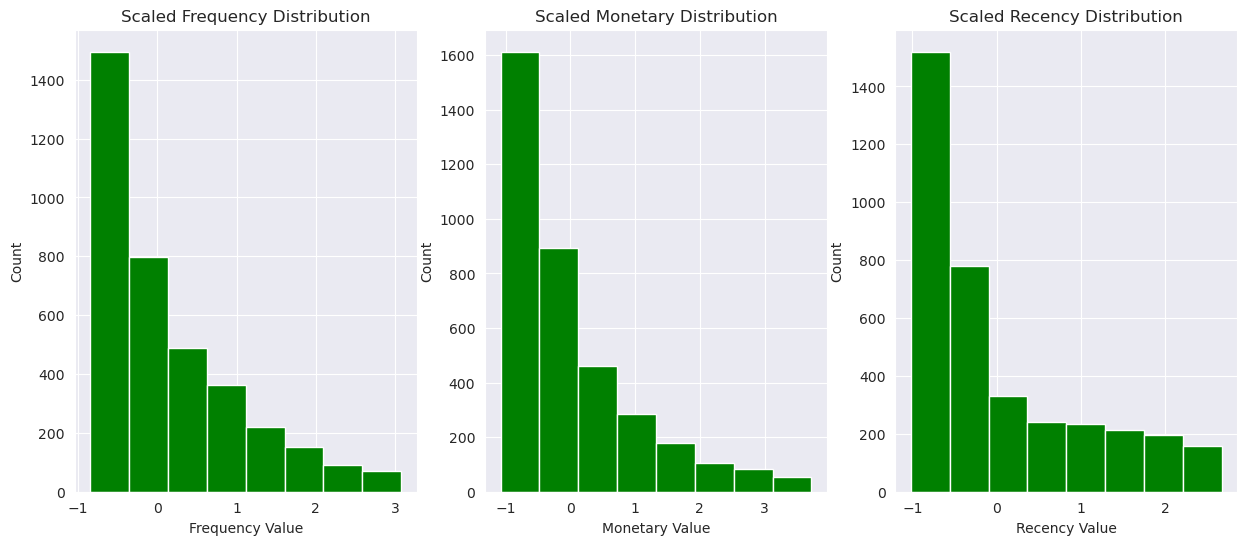

In [62]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15,6), squeeze=False)

for idx, col in enumerate(rfm_cols):

    axes[0][idx].hist(df_scaled[col], bins=8, color='green')
    axes[0][idx].set_xlabel(col + ' Value')
    axes[0][idx].set_ylabel('Count')
    # plt.axvline(df_rfm_col[col].mean(), size)
    axes[0][idx].set_title('Scaled ' + col + ' Distribution')

plt.show()    

After standardization, the shape of the distribution remains the same, but the data is now scaled.

# 5. MODELING

## 5.1 Model Prerequisites

Models to be evaluated:
- KMeans Clustering
- Agglomerative Clustering
- DBSCAN

To determine the parameters for DBSCAN, it's essential to determine the two hyperparameters in DBSCAN (MinPts and 𝜀𝜀 ) that need to be optimized to yield good clustering results.\
Finding a good combination of MinPts and 𝜀𝜀 can be problematic if the density differences in the dataset are relatively large. \
A general rule of thumb is to set MinPts >= D+1, where D is the number of dimensions in the dataset. For most cases, a minimum value of MinPts = 3 is recommended.\
Create a k-distance graph to serve as a guide in selecting the appropriate epsilon value.\
Steps:
1. Calculate the distance to the k-th nearest neighbor for each point.
2. Sort and plot the distance and use the elbow method to choose the epsilon. 

For the hyperparameter optimization, a range of values near the elbow point will be used.

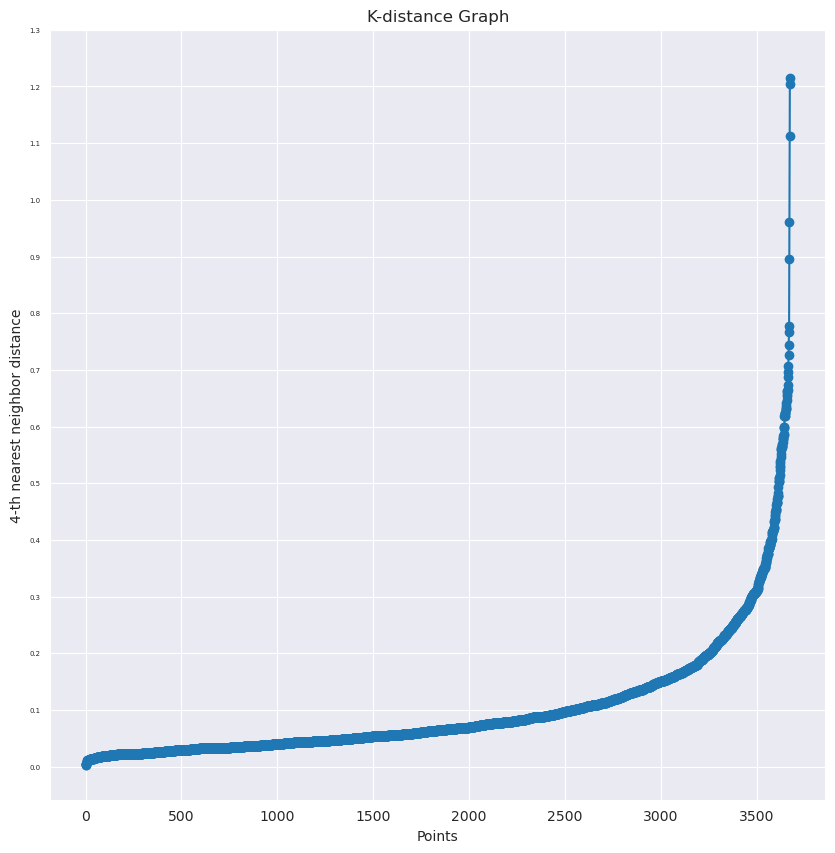

In [63]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

test_k = 4
X_scaled = df_scaled.to_numpy()
mdl_nn = NearestNeighbors(n_neighbors=test_k)
mdl_nn.fit(X_scaled)

distances, indices = mdl_nn.kneighbors(X_scaled)
distances = np.sort(distances[:, test_k-1])

plt.figure(figsize=(10,10))
plt.plot(distances, '-o')

plt.xlabel('Points')
plt.ylabel(f'{test_k}-th nearest neighbor distance')
plt.yticks(np.arange(0, max(distances)+0.1, 0.1), fontsize=5)
plt.title('K-distance Graph')
plt.show()

The estimated elbow point is between 0.1 - 0.2 

Import libraries

In [64]:
# !pip install hyperopt

In [65]:
from matplotlib import colormaps
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.pipeline import Pipeline
from hyperopt import hp, tpe, rand, fmin, Trials, STATUS_OK

#Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import time

Set the random seed

In [66]:
random_seed = 123
np.random.seed(random_seed)

In [67]:
X = df.to_numpy()
X_scaled = df_scaled.to_numpy()

In [68]:
X.shape, X_scaled.shape

((3674, 3), (3674, 3))

## 5.2 Hyperparameter Tuning

### 5.2.1 Parameters and Spaces Definition

Dictionary for model paramaters

In [69]:
models = {
    'KMeans': {
        'model': KMeans(random_state=random_seed),
        'params': {
            'cluster__n_clusters': np.arange(2,11,1),
            'cluster__init' : ['random', 'k-means++'],
            'cluster__n_init' : np.arange(2,11,2),
            'cluster__max_iter': np.arange(100,1100,100),
            'cluster__tol': [0.0001, 0.001, 0.01, 0.1],
            'cluster__algorithm' : ['lloyd', 'elkan']
        }
    },

    'Agglomerative': {
        'model': AgglomerativeClustering(),
        'params': {
            'cluster__n_clusters': np.arange(2,11,1),
            'cluster__metric' : [ 'euclidean', 'l1', 'l2', 'manhattan', 'cosine'], 
            'cluster__linkage': ['complete', 'average', 'single'],
            'cluster__compute_distances' : [True, False]
        }
    },

    'DBSCAN': {
        'model': DBSCAN(), 
        'params': {
            'cluster__eps': np.arange(0.1, 0.2, 0.01),
            'cluster__min_samples' : np.arange(4,11,1), 
            'cluster__metric': ['euclidean']
        }
    }
}

Spaces for KMeans required for SMBO using hyperopt

KMeans Clustering space definition:

In [70]:
km_space = {
    'n_clusters': hp.uniformint('n_clusters', 2, 10, q=2),
    'init' : hp.choice('init', ['random', 'k-means++']),
    'n_init' : hp.uniformint('n_init', 2,10, q=10),
    'max_iter': hp.uniformint('max_iter', 100, 1000, q=100),
    'tol': hp.choice('tol', [0.0001, 0.001, 0.01, 0.1]),
    'algorithm' : hp.choice('algorithm', ['lloyd', 'elkan'])
}

### 5.2.2 Functions for Cross-Validation

Custom function for Randomized Search and Grid Search:

In [73]:
def f_hp_optimization(desiredcv, x_data, pipe, params, njobs, f_scoring, fold):
    '''Custom function that runs GridSearchCV and RandomSearch CV using the estimator and parameter of choice.
    
    Input: 
        desiredcv - CrossValidation model (sklearn.model_selection object, i.e. RandomizedSearchCV | GridSearchCV)
        x_data - working dataset (numpy.ndarray)
        pipe - defined pipeline( Pipeline object )
        params - a dictionary of the model's parameters (dict)
        n_jobs - no of jobs (int)
        f_scoring - scoring metric or a custom function for clustering algorithms  (func)
        fold - cross-validation number of folds (int)
    Return:
        Cross-validation object fitted with data (sklearn.model_selection._search.*Randomized\Grid* SearchCV object)
    '''

    cv = None
    time_start = time.time()

    if desiredcv == GridSearchCV:
        cv = GridSearchCV(pipe, param_grid=params, n_jobs = njobs, scoring=f_scoring, cv=fold)  
    elif desiredcv == RandomizedSearchCV:
        cv = RandomizedSearchCV(pipe,param_distributions = params, n_jobs = njobs,  scoring=f_scoring, cv=fold, random_state=random_seed)  

    if cv!= None:
        cv.fit(x_data)
        
        time_end = time.time()
        runtime = time_end - time_start
        
        print(f'+++ {pipe['cluster']} {desiredcv} results: +++')
        print('Model Total running time: ', runtime)
        print("Best hyperparameters: ", cv.best_params_)
        print('Score: ', cv.best_score_)
        
        print('\n')

    return cv

Custom Scoring Functions for GridSearchCV and RandomizedSearchCV

In [74]:
def f_silhouette_score(pipex, X):
    return silhouette_score(X, pipex.fit_predict(X))

In [75]:
def f_inertia_score(pipex, X):
    return pipex['cluster'].inertia_

### 5.2.3 Functions for Bayesian Search

Objective functions for Bayesian Search using SMBO technique in ***hyperopt*** package

KMeans Clustering:

In [77]:
def km_f_objective(space):
    
    kmeans = KMeans(n_clusters = space['n_clusters'], 
                    random_state=random_seed, 
                    tol= space['tol'], 
                    n_init= space['n_init'], 
                    max_iter= space['max_iter'], 
                    init= space['init'],
                    algorithm= space['algorithm']
                    )

    clusterlabels = kmeans.fit_predict(X_scaled)
    score = kmeans.inertia_
     
    return {'loss' : -(score), 'status': STATUS_OK }

***Scoring functions for Agglomerative Clustering and DBSCAN:***

Both Agglomerative clustering and DBSCAN have no explicit loss function. Agglomerative Clustering use distance metric, and DBSCAN does not necessarily divide data into spherical clusters, so inertia is not a good metric for evaluating DBSCAN and Agglomerative Clustering models.\
In the next section, Silhouette scores will be computed for both algorithms in CV. SMBO will be skipped for both due to the lack of loss function on both algorithms

### 5.2.4 Nested Cross-Validation

This step will use nested cross-validation approach to determine the optimal parameters per clustering algorithm. In summary, this step will: 
1. Cycle through the 3 chosen cluster algorithms, namely: KMeans, Agglomerative Hierarchichal, and DBSCAN. 
2. For each algorithm, perform hyperparameter tuning.
>- KMeans - GridSearchCV, RandomizedSearchCV, and SMBO
>- Agglomerative Hierarchichal - GridSearchCV, RandomizedSearchCV
>- DBSCAN - GridSearchCV, RandomizedSearchCV

3. Apply custom scoring functions fot the ffg algorithms: 
>- KMeans -  Silhouette score via custom scoring function in CVs.No scoring from SMBO as silhouette score is not a loss function.   
>- Agglomerative Hierarchichal - Silhouette score via custom scoring function in CVs. No loss function and inertia is not applicable so SMBO is skipped.
>- DBSCAN - Silhouette score via custom scoring function in CVs. No loss function and inertia is not applicable so SMBO is skipped.

In [ ]:
#Core Nested Cross-Validation code snippet

results = []

for model_name, model_info in models.items():
    
    # Define pipeline steps
    pipeline = Pipeline(steps=[
                    ( 'scaler', [ MinMaxScaler() if model_info['model'] == DBSCAN else StandardScaler()][0] ),
                    ( 'cluster', model_info['model'] )])

    # Run Randomized Search CV using f_hp_optimization
    rscv = f_hp_optimization(desiredcv = RandomizedSearchCV, x_data=X, pipe=pipeline, params = model_info['params'], njobs= -1, f_scoring=f_silhouette_score, fold=10)
    
    # Append Randomized Search CV results
    results.append(
        {
            'model' : model_name,
            'tuning' : 'RandomizedSearchCV',
            'best_params' : rscv.best_params_,
            'Score' : rscv.best_score_        
        }
    )


    # Run Grid Search CV using f_hp_optimization
    gscv = f_hp_optimization(desiredcv = GridSearchCV, x_data=X, pipe=pipeline, params = model_info['params'], njobs= -1, f_scoring=f_silhouette_score, fold=10)
   
    # Append Grid Search CV results
    results.append(
        {
            'model' : model_name,
            'tuning' : 'GridSeachCV',
            'best_params' : gscv.best_params_,
            'Score' : gscv.best_score_        
        }
    )
   

    match model_name:

        case 'KMeans':
            print('----- SMBO: KMeans Clustering: -----')
            model_fmin = km_f_objective
            model_space = km_space

        case 'Agglomerative':
            continue
            # print('----- SMBO: Agglomerative Clustering: -----')
            # model_fmin = ac_f_objective
            # model_space = ac_space

        case 'DBSCAN':
            continue
            # print('----- SMBO: DBSCAN: -----')
            # model_fmin = db_f_objective
            # model_space = db_space

        case _:        
            continue

    # Perform SMBO. Note: X has to be scaled inside the function

    time_start = time.time()
 
    trials = Trials()    
    smbo_best = fmin( fn = model_fmin, 
                        space = model_space,
                        algo  = tpe.suggest,
                        max_evals = 100, 
                        trials = trials)    
    
    time_end = time.time()
    runtime = time_end - time_start
    print('Model Total running time: ', runtime)
    
    losses = trials.losses()

    # Append SMBO results
    results.append(
        {
            'model' : model_name,
            'tuning' : 'SMBO',
            'best_params' : smbo_best,
            'Score' : np.nan #[abs(min(losses)) if model_name == 'KMeans' else np.nan][0]  #-- DBSCAN and AC have no explicit loss function. Only KMeans has a loss function (inertia).       
        }
    )

    print(f'SMBO {model_name} best parameters: ', smbo_best)
    print('\n')

### 5.2.5 Model Selection based on model evaluation metrics

Tabulate Hyperparameter Tuning results

In [79]:
df_modelres = pd.DataFrame(results)
df_modelres.sort_values(by='Score', ascending=False)

,model,tuning,best_params,Score
4,Agglomerative,GridSeachCV,"{'cluster__compute_distances': True, 'cluster_...",0.598643
1,KMeans,GridSeachCV,"{'cluster__algorithm': 'lloyd', 'cluster__init...",0.550893
3,Agglomerative,RandomizedSearchCV,"{'cluster__n_clusters': 4, 'cluster__metric': ...",0.235377
0,KMeans,RandomizedSearchCV,"{'cluster__tol': 0.1, 'cluster__n_init': 2, 'c...",0.185916
6,DBSCAN,GridSeachCV,"{'cluster__eps': 0.15999999999999998, 'cluster...",-0.163624
5,DBSCAN,RandomizedSearchCV,"{'cluster__min_samples': 9, 'cluster__metric':...",-0.202077
2,KMeans,SMBO,"{'algorithm': 1, 'init': 1, 'max_iter': 529.0,...",NaN


KMeans and Agglomerative Hierarchichal clustering results are promising in terms of their silhouette scores. It can also be surmised that DBSCAN may not be the appropriate clustering algorithm since it has negative results. 


Compare KMeans inertia scores using GridSearch, RandomizedSearch, and SMBO
 

In [80]:
results = []

pipeline = Pipeline(steps=[
                    ( 'scaler', StandardScaler() ),
                    ( 'cluster', KMeans() ) ])

rscv = f_hp_optimization(desiredcv = RandomizedSearchCV, x_data=X, pipe=pipeline, params = models['KMeans']['params'], njobs= -1, f_scoring=f_inertia_score, fold=10)
    
# Append Randomized Search CV results
results.append(
        {   'model' : 'KMeans',
            'tuning' : 'RandomizedSearchCV',
            'best_params' : rscv.best_params_,
            'Inertia' : rscv.best_score_ })


gscv = f_hp_optimization(desiredcv = GridSearchCV, x_data=X, pipe=pipeline, params = models['KMeans']['params'], njobs= -1, f_scoring=f_inertia_score, fold=10)
    
# Append Randomized Search CV results
results.append(
        {   'model' : 'KMeans',
            'tuning' : 'GridSearchCV',
            'best_params' : gscv.best_params_,
            'Inertia' : gscv.best_score_ })


# Perform SMBO. Note: X has to be scaled
trials = Trials()    

time_start = time.time()
km_smbo = fmin( fn = km_f_objective, 
                        space =  km_space,
                        algo  = tpe.suggest,
                        max_evals = 100, 
                        trials = trials)    

time_end = time.time()
runtime = time_end - time_start
print('Model Total running time: ', runtime)

losses = trials.losses()


# Append Randomized Search CV results
results.append(
        {   'model' : 'KMeans',
            'tuning' : 'SMBO',
            'best_params' : km_smbo,
            # 'Evaluation Metric' : np.nan, #['Inertia' if model_name =='KMeans' else 'Silhouette_Score'][0],
            'Inertia' : abs(min(losses))})


    
losses = trials.losses()
print(f'SMBO {model_name} best parameters: ', km_smbo)
print('\n')

+++ KMeans() <class 'sklearn.model_selection._search.RandomizedSearchCV'> results: +++
Model Total running time:  0.4966733455657959
Best hyperparameters:  {'cluster__tol': 0.1, 'cluster__n_init': 2, 'cluster__n_clusters': 3, 'cluster__max_iter': 1000, 'cluster__init': 'random', 'cluster__algorithm': 'elkan'}
Score:  3189.7195110158727


+++ KMeans() <class 'sklearn.model_selection._search.GridSearchCV'> results: +++
Model Total running time:  248.66948199272156
Best hyperparameters:  {'cluster__algorithm': 'lloyd', 'cluster__init': 'random', 'cluster__max_iter': 800, 'cluster__n_clusters': 2, 'cluster__n_init': 2, 'cluster__tol': 0.1}
Score:  5698.073148948542


100%|██████████| 100/100 [00:01<00:00, 85.41trial/s, best loss: -7004.335409669712]
Model Total running time:  1.177306890487671
SMBO DBSCAN best parameters:  {'algorithm': 0, 'init': 0, 'max_iter': 517.0, 'n_clusters': 2.0, 'n_init': 2.0, 'tol': 3}




In [101]:
df_inertia = pd.DataFrame(results)
df_inertia

,model,tuning,best_params,Inertia
0,KMeans,RandomizedSearchCV,"{'cluster__tol': 0.1, 'cluster__n_init': 2, 'c...",3189.719511
1,KMeans,GridSearchCV,"{'cluster__algorithm': 'lloyd', 'cluster__init...",5698.073149
2,KMeans,SMBO,"{'algorithm': 0, 'init': 0, 'max_iter': 517.0,...",7004.335410


### 5.2.6 Hyperparameter selection



GridSearch and Random search methods are relatively inefficient compared to SMBO. 
SMBO works by considering the previously seen hyperparameter combinations when choosing the next set of hyperparameters to evluate. Grid and random searches, on the other hand, are completely uninformed by past evaluations and spends significant amount of time evaluating “bad” hyperparameters.



In [113]:
best_inertia = df_inertia[df_inertia.tuning == 'SMBO']

model = best_inertia['model'].item()
tuning = best_inertia['tuning'].item()
params = best_inertia['best_params'].item()

final_best_params= {}

final_best_params['n_clusters'] = int(params['n_clusters'])
final_best_params['max_iter'] = int(params['max_iter'])
final_best_params['n_init'] = int(params['n_init'])

# For SMBO results, map the best parameter indices to the original; else, assign directly

final_best_params['algorithm'] = [ models['KMeans']['params'].get('cluster__algorithm')[params['algorithm']] if tuning == 'SMBO' else params['algorithm'] ][0]
final_best_params['init'] = [ models['KMeans']['params'].get('cluster__init')[params['init']] if tuning == 'SMBO' else params['init']][0]
final_best_params['tol'] =  [ models['KMeans']['params'].get('cluster__tol')[ params['tol']]  if tuning == 'SMBO' else params['tol']][0]

print('Best model :', model)
print('Best parameters :', final_best_params )

Best model : KMeans
Best parameters : {'n_clusters': 2, 'max_iter': 517, 'n_init': 2, 'algorithm': 'lloyd', 'init': 'random', 'tol': 0.1}


## 5.3 Modeling

### 5.3.1 KMeans Modeling

Create a model using KMeans and the best parameters from SMBO

In [115]:
k_clusters = range(2,11)
cluster_labels = {}
centroids = {}
inertias = {}

for k in k_clusters:
    pipeline = Pipeline(steps=[
                        ( 'scaler', StandardScaler() ),
                        ( 'kmeans', KMeans() )])
    
    pipeline.set_params(kmeans__tol = final_best_params['tol'], 
                        kmeans__n_init = final_best_params['n_init'], 
                        kmeans__n_clusters = k, 
                        kmeans__max_iter = final_best_params['max_iter'],  
                        kmeans__init = final_best_params['init'], 
                        kmeans__algorithm = final_best_params['algorithm'],
                        kmeans__random_state = random_seed)
    
    cluster_label = pipeline.fit_predict(X)

    #Save labels, centroids, and inertias
    cluster_labels[k] = cluster_label
    centroids[k] = pipeline['kmeans'].cluster_centers_

    inertias[k] = pipeline['kmeans'].inertia_

# Display inertias per k clusters
for k in k_clusters:
    print(f'n_clusters = {k} : {inertias[k]}')

n_clusters = 2 : 7004.335409669711
n_clusters = 3 : 3526.007172865434
n_clusters = 4 : 2746.712778497361
n_clusters = 5 : 2499.090009750973
n_clusters = 6 : 2420.6525726448513
n_clusters = 7 : 2042.0398054876105
n_clusters = 8 : 1748.5812465399872
n_clusters = 9 : 1547.6207911387505
n_clusters = 10 : 1461.7522858499187


There is no direct way to determine the optimal # of Ks from the training loss itself; loss continue to decrease for larger numbers of centers (as any given point's distance to the centers becomes lesser as they are closer). 

An Inertia plot is useful for plotting the loss (inertia) versus the number of clusters.

### 5.3.2 Selecting the best K- clusters. Inertia Plot

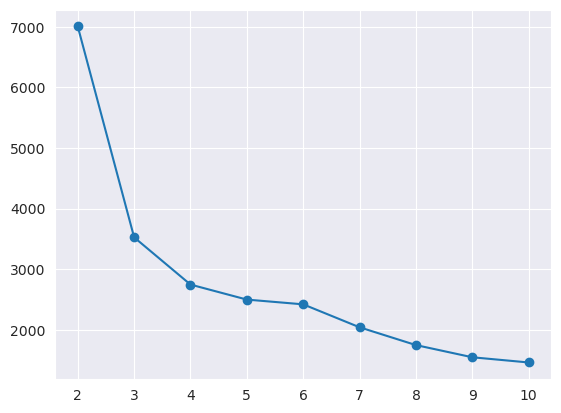

In [85]:
plt.plot(k_clusters, inertias.values(), '-o')
plt.show()

Based on the Inertia plot, the knee point is most likely at n_clusters = 3 or 4.\
To further help in deciding the optimal n_clusters, the following silhouette analysis will focus on n_clusters = 2 to 5. 

### 5.3.3 Silhouette Plot

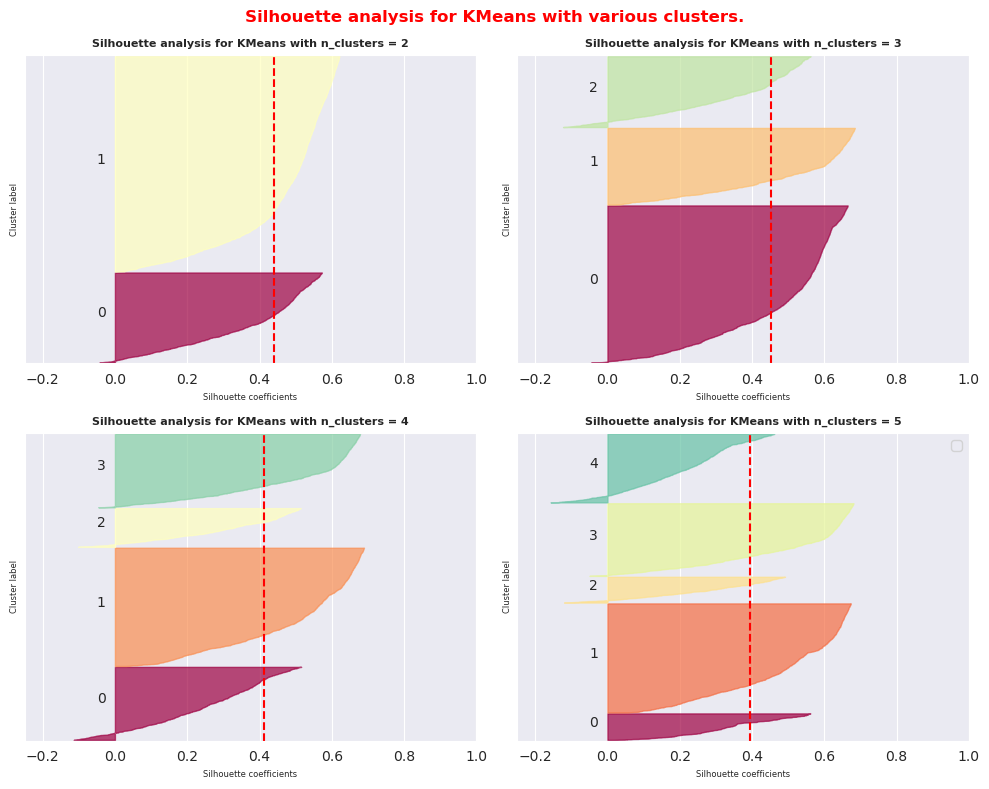

In [98]:
fig, ax1 = plt.subplots(2,2, figsize=(10,8))
avg_silhouette_scores = []
avg_per_k = {}

for i, k in enumerate(k_clusters[0:4]):

    xctr = yctr = 0
    if i%2 != 0:
        yctr = 1
    if i>=2:
        xctr = 1
    
    # The silhouette coefficient can range from -1, 1 
    ax1[xctr][yctr].set_xlim([-0.25, 1])
    ax1[xctr][yctr].set_ylim([0, len(X_scaled) + (k + 1) * 10])

    
    clusterer = KMeans(n_clusters=k, random_state=random_seed, max_iter=1000)
    cl_labels = clusterer.fit_predict(X_scaled)

  
    silhouette_avg  = silhouette_score(X_scaled, cl_labels)
    avg_silhouette_scores.append(silhouette_avg)
    avg_per_k[k] = silhouette_avg
    
    sample_silhouette_values = silhouette_samples(X_scaled, cl_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cl_labels == i]

        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0] 
        y_upper = y_lower + size_cluster_i

        cmap = colormaps.get_cmap('Spectral')
        color = cmap(float(i) / k)
        ax1[xctr][yctr].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1[xctr][yctr].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

   
    ax1[xctr][yctr].set_title("Silhouette analysis for KMeans with n_clusters = %d" % k, fontsize=8, fontweight='bold')
    ax1[xctr][yctr].set_xlabel("Silhouette coefficients", fontsize=6)
    ax1[xctr][yctr].set_ylabel("Cluster label",  fontsize=6)


    ax1[xctr][yctr].axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1[xctr][yctr].set_yticks([])  # Clear the yaxis labels / ticks
    ax1[xctr][yctr].set_xticks([ -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend()
    plt.tight_layout()
    plt.suptitle("Silhouette analysis for KMeans with various clusters.", color='red',
                 fontsize=12, fontweight='bold')

    

Between n_clusters=3 and n_clusters=4, the former has low negative coefficient values, and the cluster label heights is even better compared to the latter.\
The optimal number of clusters for this dataset using KMeans algorithm is 3. 


### 5.3.4 Assigning Labels

In [ ]:
df_labeled = df.copy(deep=True)
df_labeled['Cluster'] = cluster_labels[3]

df_labeled['Cluster'].value_counts()

Cluster
1    1844
0     950
2     880
Name: count, dtype: int64

## 6 Customer Segmentation Analysis

### 6.1 Cluster Labels and Color Designation

In [110]:
dict_colors = { 0: '#4196c6',  #blue
                1: '#fda848',  #orange 
                2: '#69c641',  #green
                3: '#fd4848',  #red
                }

label_colors=  df_labeled['Cluster'].map(dict_colors) 

### 6.2 Clusters 3D Plot

3D Plot for 3-Cluster Data

Text(0.5, 0, 'Monetary')

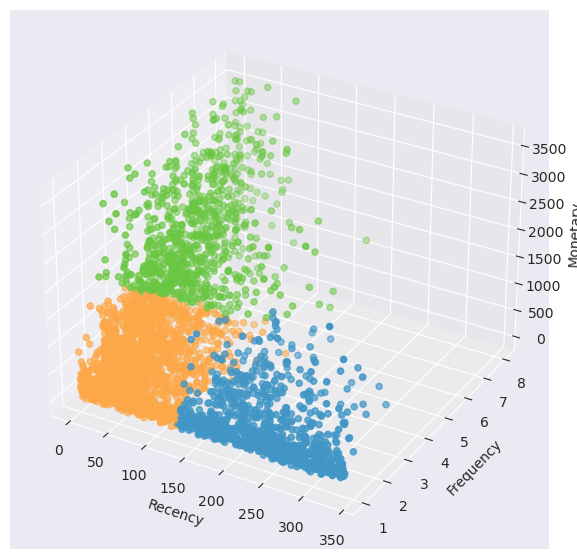

In [111]:
sns.set_style ("darkgrid")

fig = plt.figure (figsize=(14,7))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    df_labeled.Recency,
    df_labeled.Frequency, 
    df_labeled.Monetary,
    c=label_colors,
    marker='o')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

### 6.3 Cluster Distribution

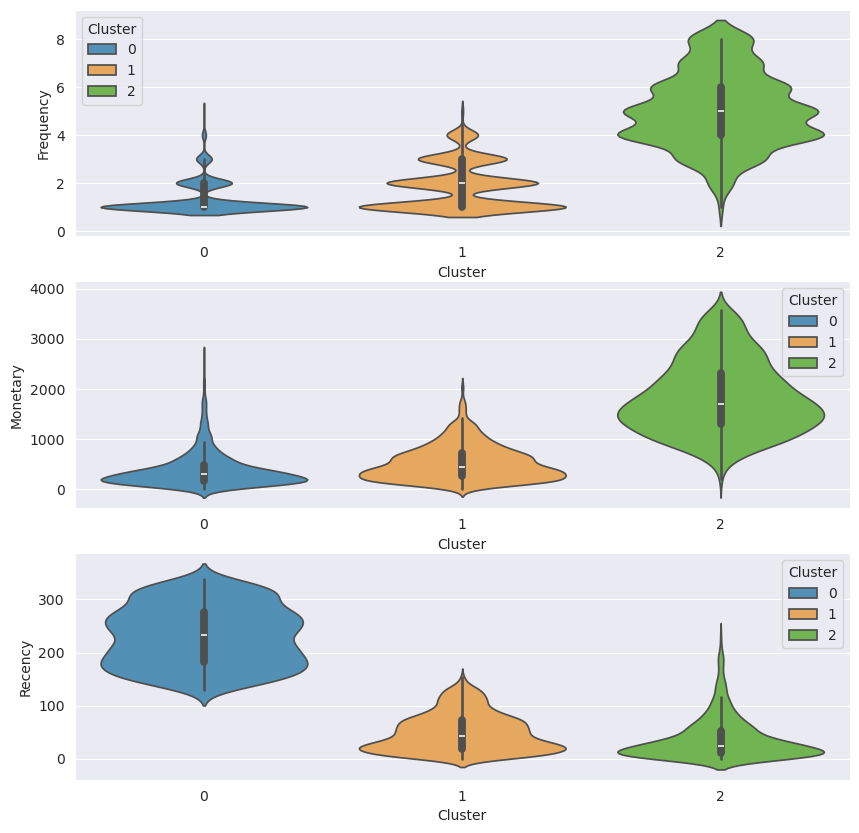

In [112]:
rfm_cols = df_labeled.columns.to_list()
rfm_cols.remove('Cluster')
rfm_cols

plt.figure(figsize=(10,10))

for idx, col in enumerate(rfm_cols):

    plt.subplot(3, 1, idx+1)
    sns.violinplot(x=df_labeled['Cluster'], y=df_labeled[col], hue=df_labeled['Cluster'], palette=dict_colors)


## 6.4 Cluster Analysis & Recommendations

<div class="alert alert-block alert-info">
Cluster 0: <b>Recent</b>


- Less frequent buyers who are low-spenders but made recent purchases.

Recommendations:
1. Identify recently purhcased products and target "similar products" ad recommendations
2. Enhance customer experience and services
3. Encourage to purchase more by offering incentives

</div>

<div class="alert alert-block alert-warning">
Cluster 1: <b>Regulars</b>

- Moderate buyers that are not necessarily big spenders and haven't purchased recently. 

Recommendation: 
1. Offer subscription on frequently bought items (whenever applicable)
2. Recommend "Frequently bought together" items
3. Implement customer retention and loyalty programs


</div>

<div class="alert alert-block alert-success">
Cluster 2: <b>VIPs</b>

- Frequent shoppers who are big spenders, although no recent purchases.

Recommendations:
1. Re-engage by implementing rewards and loyalty programs
2. Target for Exclusive Perks
3. Offer subscription on frequently bought items (whenever applicable)
</div>